In [17]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder

# 📌 파일 경로 설정
train_path = "/Users/yudayeon/Desktop/캡스톤_결과/open/train.csv"

# 데이터 로드
df = pd.read_csv(train_path)

# --------------------------------------- 결측치 처리를 위한 시술 ---------------------------------------------------
# 📌 Label Encoding을 위한 객체 생성
le_surgery_code = LabelEncoder()
le_age_group = LabelEncoder()
le = LabelEncoder()

df["시술 유형"] = le.fit_transform(df["시술 유형"])

# --------------------------------------- 결측치 처리 ---------------------------------------------------
# 특정 시술 유형이 NaN인 행 삭제
df = df.dropna(subset=["특정 시술 유형"])

# 난자 채취, 배아 이식, 난자 해동 등 관련 변수들
embryo_timing_columns = [
    "난자 채취 경과일", "난자 해동 경과일", "난자 혼합 경과일",
    "배아 이식 경과일", "배아 해동 경과일", "단일 배아 이식 여부", "착상 전 유전 검사 사용 여부", "착상 전 유전 진단 사용 여부",
    "배아 생성 주요 이유", "총 생성 배아 수", "미세주입된 난자 수",
    "미세주입에서 생성된 배아 수", "이식된 배아 수", "미세주입 배아 이식 수",
    "저장된 배아 수", "미세주입 후 저장된 배아 수", "해동된 배아 수",
    "해동 난자 수", "수집된 신선 난자 수", "저장된 신선 난자 수",
    "혼합된 난자 수", "파트너 정자와 혼합된 난자 수", "기증자 정자와 혼합된 난자 수",
    "동결 배아 사용 여부", "신선 배아 사용 여부", "기증 배아 사용 여부",
    "대리모 여부"
]

# 📌 DI를 시행한 경우 (시술 유형 == 1) 해당 변수들의 결측값을 -1로 채우기
df.loc[df["시술 유형"] == 0, embryo_timing_columns] = df.loc[df["시술 유형"] == 0, embryo_timing_columns].fillna(-1)

# 결측값을 0으로 처리할 변수들
columns_to_fill = [
    "착상 전 유전 검사 사용 여부", "PGD 시술 여부", "PGS 시술 여부" , 
]

# 결측값을 0으로 채우기
df[columns_to_fill] = df[columns_to_fill].fillna(0)



# 결측값을 -1으로 처리할 변수들
columns_to_fill = [
    "난자 채취 경과일", "배아 이식 경과일", "난자 혼합 경과일" , 
]

# 결측값을 -1으로 채우기
df[columns_to_fill] = df[columns_to_fill].fillna(-1)




# 결측값을 0으로 처리할 변수들(보류 -1로 비교할 예정)
columns_to_fill = [
    "임신 시도 또는 마지막 임신 경과 연수", "난자 해동 경과일", "배아 해동 경과일"
]

# 결측값을 0으로 채우기
df[columns_to_fill] = df[columns_to_fill].fillna(0)

# 각 변수별 결측값 개수 출력
missing_values = df.isnull().sum()

# 결측값이 있는 변수만 출력
print(missing_values[missing_values > 0])

# ------------------------------------------ 결측치 처리 ---------------------------------------------------
# "알 수 없음"을 -1로 변경할 컬럼 리스트
columns_to_replace = ["시술 당시 나이", "난자 출처", "난자 기증자 나이", "정자 기증자 나이", "배란 유도 유형", "배아 생성 주요 이유"]

for col in columns_to_replace:
    df[col] = df[col].replace("알 수 없음", -1)

# 레이블 인코딩을 적용할 컬럼 리스트
label_encode_columns = "시술 시기 코드", "시술 당시 나이", "배란 유도 유형", "총 시술 횟수", "클리닉 내 총 시술 횟수", "IVF 시술 횟수", "DI 시술 횟수", "총 임신 횟수", "IVF 임신 횟수", "DI 임신 횟수", "총 출산 횟수", "IVF 출산 횟수", "DI 출산 횟수", "기증자 정자와 혼합된 난자 수", "난자 출처", "정자 출처", "난자 기증자 나이", "정자 기증자 나이"

# 컬럼별로 LabelEncoder 생성 및 적용
label_encoders = {}  # 각 컬럼별 LabelEncoder 저장용

for col in label_encode_columns:    
    le = LabelEncoder()
    # -1이 아닌 값들만 학습
    unique_values = df.loc[df[col] != -1, col].unique()
    le.fit(unique_values)

    # Label Encoding 적용 (단, -1 값은 그대로 유지)
    df[col] = df[col].apply(lambda x: -1 if x == -1 else le.transform([x])[0])

# 📌 "배아 생성 주요 이유" 원-핫 인코딩 (복수 선택 가능)
df["배아 생성 주요 이유"] = df["배아 생성 주요 이유"].astype(str).apply(lambda x: x.split(',') if x != "-1" else [])

# 개별 요소를 원-핫 인코딩으로 변환
from sklearn.preprocessing import MultiLabelBinarizer

mlb = MultiLabelBinarizer()
encoded_배아생성 = mlb.fit_transform(df["배아 생성 주요 이유"])
encoded_배아생성_df = pd.DataFrame(encoded_배아생성, columns=[f"배아 생성 주요 이유_{c}" for c in mlb.classes_])

# 기존 "배아 생성 주요 이유" 컬럼 제거 후 원-핫 인코딩한 값 추가
df = df.drop("배아 생성 주요 이유", axis=1)
df = pd.concat([df, encoded_배아생성_df], axis=1)


# 📌 특정 시술 유형 (유효한 값 목록)
valid_treatments = {"IVF", "IUI", "FER", "IVI", "BLASTOCYST", "AH", "GIFT", "ICI", "Generic DI", "ICSI", "Unknown"}

# 📌 유효한 값은 원-핫 인코딩 수행
for treatment in valid_treatments:
    df[f"특정 시술 - {treatment}"] = (df["특정 시술 유형"] == treatment).astype(int)

# 📌 "MIXED"에 해당하는 값만 추출
mixed_values = df[~df["특정 시술 유형"].isin(valid_treatments)]["특정 시술 유형"]

# 📌 "MIXED" 값만 레이블 인코딩 수행
label_encoder = LabelEncoder()
df["특정 시술 - MIXED"] = 0  # 기본값 0으로 초기화

if not mixed_values.empty:
    train_encoded = label_encoder.fit_transform(mixed_values) + 1  # 1부터 시작
    df.loc[~df["특정 시술 유형"].isin(valid_treatments), "특정 시술 - MIXED"] = train_encoded

# 📌 원본 컬럼 삭제
df.drop(columns=["특정 시술 유형"], inplace=True)


# 📌 CSV 파일 저장 경로 설정
csv_file_path = "/Users/yudayeon/Desktop/캡스톤_결과/open/train__.csv"

# 📌 CSV 파일로 저장
df.to_csv(csv_file_path, index=False)

/var/folders/r_/v0bsr2bn417b78f3hwntq0sc0000gn/T/ipykernel_39519/23487262.py:36: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df.loc[df["시술 유형"] == 0, embryo_timing_columns] = df.loc[df["시술 유형"] == 0, embryo_timing_columns].fillna(-1)


Series([], dtype: int64)


In [21]:
import pandas as pd

# 파일 경로 설정
file_path = "/Users/yudayeon/Desktop/캡스톤_결과/open/train__.csv"

# CSV 파일 로드
df = pd.read_csv(file_path)

# ✅ 결측값이 있는 행 출력
print("✅ 결측값이 있는 행:")
print(df[df.isnull().any(axis=1)])

# ✅ 결측값이 있는 행 삭제
df_cleaned = df.dropna()

# ✅ 삭제 후 데이터 크기 확인
print("\n✅ 결측값 제거 후 데이터 크기:", df_cleaned.shape)

# ✅ 정제된 데이터 저장 (선택 사항)
cleaned_file_path = "/Users/yudayeon/Desktop/캡스톤_결과/open/train__.csv"
df_cleaned.to_csv(cleaned_file_path, index=False)

print("\n✅ 정제된 데이터가 저장되었습니다:", cleaned_file_path)

✅ 결측값이 있는 행:
                  ID  시술 시기 코드  시술 당시 나이  임신 시도 또는 마지막 임신 경과 연수  시술 유형  \
256347  TRAIN_256349       6.0       2.0                    0.0    1.0   
256348  TRAIN_256350       4.0       1.0                    0.0    1.0   
256349           NaN       NaN       NaN                    NaN    NaN   
256350           NaN       NaN       NaN                    NaN    NaN   

        배란 자극 여부  배란 유도 유형  단일 배아 이식 여부  착상 전 유전 검사 사용 여부  착상 전 유전 진단 사용 여부  \
256347       1.0       0.0          0.0               0.0               0.0   
256348       0.0      -1.0          0.0               0.0               0.0   
256349       NaN       NaN          NaN               NaN               NaN   
256350       NaN       NaN          NaN               NaN               NaN   

        ...  특정 시술 - AH  특정 시술 - Unknown  특정 시술 - FER  특정 시술 - ICI  \
256347  ...           0                0            0            0   
256348  ...           0                0            0            0   
256349  ..

✅ VIF 계산 중...


/opt/anaconda3/lib/python3.12/site-packages/statsmodels/regression/linear_model.py:1785: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.uncentered_tss
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)



✅ VIF 10 이상인 변수 제거 완료
제거된 변수 개수: 41
남은 변수 개수: 45

✅ PCA 적용 완료 (변수 20개로 축소)
변환된 데이터 크기: (256347, 20)

🔹 [로지스틱 회귀] 성능 평가
정확도: 0.6713536826971965
ROC-AUC: 0.6782329953067463
              precision    recall  f1-score   support

         0.0       0.70      0.90      0.78     38025
         1.0       0.52      0.22      0.31     19012

    accuracy                           0.67     57037
   macro avg       0.61      0.56      0.55     57037
weighted avg       0.64      0.67      0.63     57037


🔹 [랜덤 포레스트] 성능 평가
정확도: 0.7024387678173817
ROC-AUC: 0.7309953988712343
              precision    recall  f1-score   support

         0.0       0.74      0.85      0.79     38025
         1.0       0.58      0.41      0.48     19012

    accuracy                           0.70     57037
   macro avg       0.66      0.63      0.63     57037
weighted avg       0.69      0.70      0.69     57037



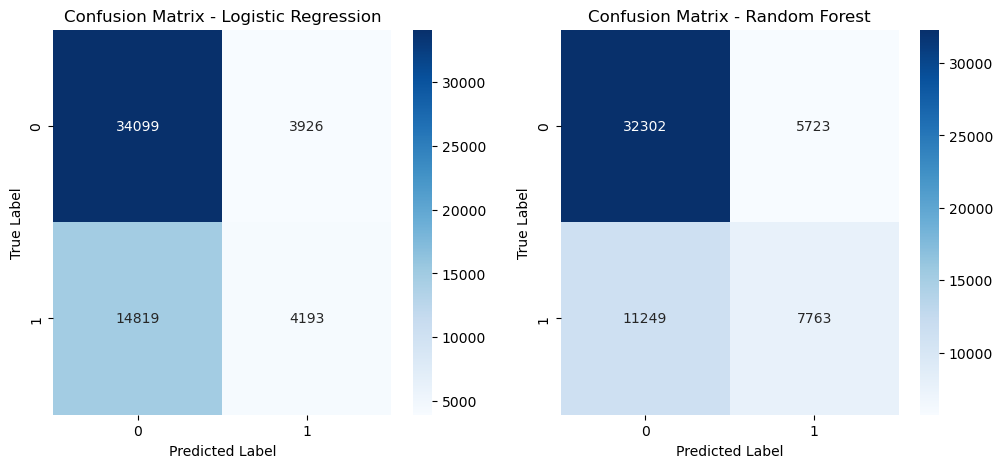

In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report, confusion_matrix
from statsmodels.stats.outliers_influence import variance_inflation_factor
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE

# ✅ 데이터 로드
file_path = "/Users/yudayeon/Desktop/캡스톤_결과/open/train_cleaned.csv"
df = pd.read_csv(file_path)

# ✅ 1열(ID) 제거 & 종속변수 지정
X = df.iloc[:, 1:].drop(columns=["임신 성공 여부"])  # ID 및 종속변수 제거
y = df["임신 성공 여부"]

# ✅ 1. VIF 분석 후 다중공선성이 높은 변수 제거
print("✅ VIF 계산 중...")
vif_data = pd.DataFrame()
vif_data["Feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

# ✅ VIF 값이 10 이상인 변수 제거
high_vif_features = vif_data[vif_data["VIF"] > 10]["Feature"].tolist()
X_vif_filtered = X.drop(columns=high_vif_features)

print("\n✅ VIF 10 이상인 변수 제거 완료")
print("제거된 변수 개수:", len(high_vif_features))
print("남은 변수 개수:", X_vif_filtered.shape[1])

# ✅ 2. 데이터 스케일링
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_vif_filtered)

# ✅ 3. PCA 적용 (변수를 20개로 줄이기)
pca = PCA(n_components=20)
X_pca = pca.fit_transform(X_scaled)

print("\n✅ PCA 적용 완료 (변수 20개로 축소)")
print("변환된 데이터 크기:", X_pca.shape)  # (샘플 수, 20)


# ✅ 5. 데이터 분할 (학습용 80%, 테스트용 20%)
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42, stratify=y_resampled)

# ✅ 6. 모델 학습 및 평가

# 1️⃣ 로지스틱 회귀
logistic_model = LogisticRegression()
logistic_model.fit(X_train, y_train)
logistic_pred = logistic_model.predict(X_test)

# 2️⃣ 랜덤 포레스트
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
rf_pred = rf_model.predict(X_test)

# ✅ 7. 성능 평가
print("\n🔹 [로지스틱 회귀] 성능 평가")
print("정확도:", accuracy_score(y_test, logistic_pred))
print("ROC-AUC:", roc_auc_score(y_test, logistic_model.predict_proba(X_test)[:, 1]))
print(classification_report(y_test, logistic_pred))

print("\n🔹 [랜덤 포레스트] 성능 평가")
print("정확도:", accuracy_score(y_test, rf_pred))
print("ROC-AUC:", roc_auc_score(y_test, rf_model.predict_proba(X_test)[:, 1]))
print(classification_report(y_test, rf_pred))

# ✅ 8. 컨퓨전 매트릭스 시각화
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# 로지스틱 회귀 Confusion Matrix
cm_logistic = confusion_matrix(y_test, logistic_pred)
sns.heatmap(cm_logistic, annot=True, fmt="d", cmap="Blues", ax=axes[0])
axes[0].set_title("Confusion Matrix - Logistic Regression")
axes[0].set_xlabel("Predicted Label")
axes[0].set_ylabel("True Label")

# 랜덤 포레스트 Confusion Matrix
cm_rf = confusion_matrix(y_test, rf_pred)
sns.heatmap(cm_rf, annot=True, fmt="d", cmap="Blues", ax=axes[1])
axes[1].set_title("Confusion Matrix - Random Forest")
axes[1].set_xlabel("Predicted Label")
axes[1].set_ylabel("True Label")

plt.show()

In [5]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE

# 📌 데이터 파일 경로 설정
train_path = "/Users/yudayeon/Desktop/캡스톤_결과/open/train.csv"
test_path = "/Users/yudayeon/Desktop/캡스톤_결과/open/train.csv"
submission_path = "/Users/yudayeon/Desktop/캡스톤_결과/sample_submission.csv"

# 📌 데이터 로드 (ID 컬럼 유지)
train_df = pd.read_csv(train_path, encoding="utf-8-sig")
test_df = pd.read_csv(test_path, encoding="utf-8-sig")

# 📌 ID 컬럼 따로 저장 (Test 데이터)
test_ids = test_df.iloc[:, 0]  # 첫 번째 열을 ID로 저장
test_df = test_df.iloc[:, 1:]  # ID 제외한 나머지 데이터 사용

# 📌 종속 변수 설정 (임신 성공 여부)
target_col = "임신 성공 여부"

# 📌 Feature Selection (논문 기반 주요 변수 선택)
selected_features = [
    "시술 당시 나이", "총 생성 배아 수", "미세주입된 난자 수",
    "이식된 배아 수", "미세주입 배아 이식 수", "배란 자극 여부",
    "난자 채취 경과일", "배아 이식 경과일", "정자 출처"
]

# 📌 Feature Engineering (새로운 변수 생성)
train_df["IVF 성공률"] = train_df["이식된 배아 수"] / (train_df["총 생성 배아 수"] + 1)
test_df["IVF 성공률"] = test_df["이식된 배아 수"] / (test_df["총 생성 배아 수"] + 1)

# 🔹 **무한대 (inf) 값 또는 NaN이 발생할 가능성이 있는지 체크**
train_df.replace([np.inf, -np.inf], np.nan, inplace=True)
test_df.replace([np.inf, -np.inf], np.nan, inplace=True)

# 🔹 **NaN 값이 있다면 0으로 대체**
train_df.fillna(0, inplace=True)
test_df.fillna(0, inplace=True)

# 📌 나이 그룹 생성 (-1, 0, 1로 변환)
train_df["나이 그룹"] = train_df["시술 당시 나이"].apply(lambda x: -1 if x == -1 else (0 if x == 0 else 1))
test_df["나이 그룹"] = test_df["시술 당시 나이"].apply(lambda x: -1 if x == -1 else (0 if x == 0 else 1))

# 선택된 변수 리스트에 추가
selected_features.append("나이 그룹")
selected_features.append("IVF 성공률")

# 📌 독립 변수(X)와 종속 변수(y) 분리
X = train_df[selected_features]
y = train_df[target_col]

# 📌 데이터 불균형 해결 (논문 방식 - SMOTE 적용)
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

print(f"✅ 데이터 균형 조정 후 클래스 분포:\n{y_resampled.value_counts()}")

# 📌 Train/Test 데이터 분리
X_train, X_val, y_train, y_val = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42, stratify=y_resampled)

# 📌 XGBoost 모델 학습
xgb = XGBClassifier(n_estimators=200, max_depth=6, learning_rate=0.05, random_state=42)
xgb.fit(X_train, y_train)

# 📌 하이퍼파라미터 튜닝 (GridSearchCV 적용)
param_grid = {
    "n_estimators": [100, 200, 300],
    "max_depth": [4, 6, 8],
    "learning_rate": [0.01, 0.05, 0.1],
    "subsample": [0.8, 1.0],
    "colsample_bytree": [0.8, 1.0]
}

grid_search = GridSearchCV(xgb, param_grid, cv=5, scoring="accuracy", n_jobs=-1)
grid_search.fit(X_train, y_train)

# 최적의 모델 선정
best_xgb = grid_search.best_estimator_
print(f"\n✅ 최적의 하이퍼파라미터: {grid_search.best_params_}")

# 📌 검증 데이터 평가
y_val_pred = best_xgb.predict(X_val)

# 📌 컨퓨전 매트릭스 생성 및 성능 평가
conf_matrix = confusion_matrix(y_val, y_val_pred)
accuracy = accuracy_score(y_val, y_val_pred)
report = classification_report(y_val, y_val_pred)

# 📌 결과 출력
print(f"\n✅ XGBoost 모델 정확도: {accuracy:.4f}")
print("\n✅ 분류 보고서:")
print(report)

# 📌 컨퓨전 매트릭스 시각화
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["실패", "성공"], yticklabels=["실패", "성공"])
plt.xlabel("예측값")
plt.ylabel("실제값")
plt.title("Confusion Matrix (XGBoost)")
plt.show()

# 📌 Feature Importance 시각화
feature_importance = best_xgb.feature_importances_
importance_df = pd.DataFrame({"Feature": X_train.columns, "Importance": feature_importance})
importance_df = importance_df.sort_values(by="Importance", ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x="Importance", y="Feature", data=importance_df[:10])  # 상위 10개만 표시
plt.title("XGBoost Feature Importance")
plt.show()

# 📌 Test 데이터 예측
X_test = test_df[selected_features]
y_test_pred = best_xgb.predict(X_test)

# 📌 예측 결과를 DataFrame으로 변환
submission_df = pd.DataFrame({"ID": test_ids, "임신 성공 여부": y_test_pred})

# 📌 예측 결과 저장
submission_df.to_csv(submission_path, index=False, encoding="utf-8-sig")

print(f"\n✅ 예측 완료! 결과 저장: {submission_path}")

ValueError: could not convert string to float: '만18-34세'

In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE

# ✅ 1열(아이디) 제외하고 데이터 준비
X = df.iloc[:, 1:].drop(columns=["임신 성공 여부"])  # 1열(ID)과 종속변수 제거
y = df["임신 성공 여부"]

# ✅ 랜덤 포레스트를 이용해 변수 중요도 계산
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X, y)

# ✅ 변수 중요도 확인
feature_importances = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=False)

# ✅ 상위 20개 독립 변수 선택
top_20_features = feature_importances[:20].index
X_selected = X[top_20_features]

# ✅ SMOTE 적용 (임신 성공 개수를 100,000개로 설정)
success_count = 100000  # 목표 샘플 수
smote = SMOTE(sampling_strategy={1: success_count}, random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_selected, y)

# ✅ 데이터 분할 (학습용 80%, 테스트용 20%)
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42, stratify=y_resampled)

# ✅ 모델 학습 및 평가

# 1️⃣ 로지스틱 회귀
logistic_model = LogisticRegression()
logistic_model.fit(X_train, y_train)
logistic_pred = logistic_model.predict(X_test)

# 2️⃣ 랜덤 포레스트
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
rf_pred = rf_model.predict(X_test)

# ✅ 성능 평가
print("\n🔹 [로지스틱 회귀] 성능 평가")
print("정확도:", accuracy_score(y_test, logistic_pred))
print("ROC-AUC:", roc_auc_score(y_test, logistic_model.predict_proba(X_test)[:, 1]))
print(classification_report(y_test, logistic_pred))

print("\n🔹 [랜덤 포레스트] 성능 평가")
print("정확도:", accuracy_score(y_test, rf_pred))
print("ROC-AUC:", roc_auc_score(y_test, rf_model.predict_proba(X_test)[:, 1]))
print(classification_report(y_test, rf_pred))

# ✅ 컨퓨전 매트릭스 시각화
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# 로지스틱 회귀 Confusion Matrix
cm_logistic = confusion_matrix(y_test, logistic_pred)
sns.heatmap(cm_logistic, annot=True, fmt="d", cmap="Blues", ax=axes[0])
axes[0].set_title("Confusion Matrix - Logistic Regression")
axes[0].set_xlabel("Predicted Label")
axes[0].set_ylabel("True Label")

# 랜덤 포레스트 Confusion Matrix
cm_rf = confusion_matrix(y_test, rf_pred)
sns.heatmap(cm_rf, annot=True, fmt="d", cmap="Blues", ax=axes[1])
axes[1].set_title("Confusion Matrix - Random Forest")
axes[1].set_xlabel("Predicted Label")
axes[1].set_ylabel("True Label")

plt.show()

# ✅ 선택된 상위 20개 독립 변수 출력
print("\n✅ 임신 성공 여부에 영향을 미치는 상위 20개 변수:")
print(feature_importances[:20])

ValueError: Input y contains NaN.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report, confusion_matrix
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE

# ✅ 데이터 준비
X = df[[ "불임 원인 - 남성 요인"]]
y = df["임신 성공 여부"]

# ✅ 데이터 불균형 확인
print("✅ 원본 데이터 분포:")
print(y.value_counts())

# ✅ SMOTE 적용 (임신 성공 개수를 100,000개로 설정)
success_count = 100000  # 목표 샘플 수
smote = SMOTE(sampling_strategy={1: success_count}, random_state=42)

X_resampled, y_resampled = smote.fit_resample(X, y)

# ✅ 오버샘플링 후 데이터 분포 확인
print("\n✅ SMOTE 적용 후 데이터 분포:")
print(y_resampled.value_counts())

# ✅ 데이터 분할 (학습용 80%, 테스트용 20%)
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42, stratify=y_resampled)

# ✅ 모델 학습 및 평가

# 1️⃣ 로지스틱 회귀
logistic_model = LogisticRegression()
logistic_model.fit(X_train, y_train)
logistic_pred = logistic_model.predict(X_test)

# 2️⃣ 랜덤 포레스트
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
rf_pred = rf_model.predict(X_test)

# ✅ 성능 평가
print("\n🔹 [로지스틱 회귀] 성능 평가")
print("정확도:", accuracy_score(y_test, logistic_pred))
print("ROC-AUC:", roc_auc_score(y_test, logistic_model.predict_proba(X_test)[:, 1]))
print(classification_report(y_test, logistic_pred))

print("\n🔹 [랜덤 포레스트] 성능 평가")
print("정확도:", accuracy_score(y_test, rf_pred))
print("ROC-AUC:", roc_auc_score(y_test, rf_model.predict_proba(X_test)[:, 1]))
print(classification_report(y_test, rf_pred))

# ✅ 컨퓨전 매트릭스 시각화
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# 로지스틱 회귀 Confusion Matrix
cm_logistic = confusion_matrix(y_test, logistic_pred)
sns.heatmap(cm_logistic, annot=True, fmt="d", cmap="Blues", ax=axes[0])
axes[0].set_title("Confusion Matrix - Logistic Regression")
axes[0].set_xlabel("Predicted Label")
axes[0].set_ylabel("True Label")

# 랜덤 포레스트 Confusion Matrix
cm_rf = confusion_matrix(y_test, rf_pred)
sns.heatmap(cm_rf, annot=True, fmt="d", cmap="Blues", ax=axes[1])
axes[1].set_title("Confusion Matrix - Random Forest")
axes[1].set_xlabel("Predicted Label")
axes[1].set_ylabel("True Label")

plt.show()

시술 유형
0    6291
1    6291
Name: count, dtype: int64


/var/folders/r_/v0bsr2bn417b78f3hwntq0sc0000gn/T/ipykernel_10150/545947941.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=success_rates_df["시술 유형"], y=success_rates_df["임신 성공 여부"], palette="coolwarm")


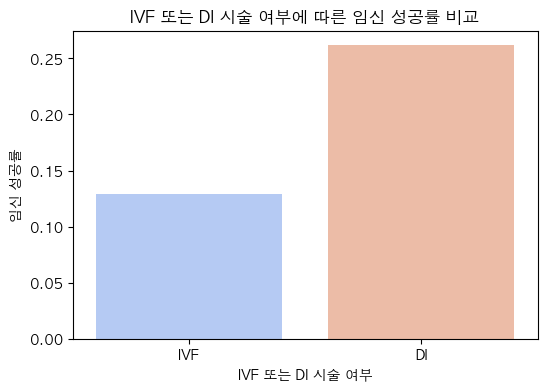

   시술 유형  임신 성공 여부
0      0  0.128914
1      1  0.261605


In [89]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import seaborn as sns

# 📌 IVF 또는 DI 여부별 임신 성공률 계산
success_rates = df.groupby("시술 유형")["임신 성공 여부"].mean()

# 📌 데이터프레임 변환
success_rates_df = success_rates.reset_index()

di_sample = resample(di_group, replace=False, n_samples=len(ivf_group), random_state=42)

# IVF 그룹과 샘플링된 DI 그룹 합치기
balanced_df = pd.concat([ivf_group, di_sample])

# 샘플 크기 확인
print(balanced_df["시술 유형"].value_counts())

# 📌 MacOS에서 한글 폰트 설정
plt.rcParams['font.family'] = "AppleGothic"  # 애플 기본 한글 폰트

# 📌 시각화
plt.figure(figsize=(6, 4))
sns.barplot(x=success_rates_df["시술 유형"], y=success_rates_df["임신 성공 여부"], palette="coolwarm")
plt.xticks([0, 1], ["IVF", "DI"])
plt.ylabel("임신 성공률")
plt.xlabel("IVF 또는 DI 시술 여부")
plt.title("IVF 또는 DI 시술 여부에 따른 임신 성공률 비교")
plt.show()

# 결과 출력
print(success_rates_df)

In [81]:
import scipy.stats as stats
import pandas as pd

# IVF(0) vs DI(1) 그룹의 성공/실패 빈도 테이블 생성
contingency_table = pd.crosstab(df["시술 유형"], df["임신 성공 여부"])

# 카이제곱 검정 실행
chi2, p, dof, expected = stats.chi2_contingency(contingency_table)

# 결과 출력
print(f"카이제곱 통계량: {chi2:.4f}")
print(f"p-value: {p:.4f}")

# p-value < 0.05이면 유의미한 차이가 있음!
if p < 0.05:
    print("✅ IVF와 DI 간의 임신 성공률 차이가 통계적으로 유의미함!")
else:
    print("❌ IVF와 DI 간의 차이가 유의미하지 않음. 단순한 우연일 가능성 있음.")

카이제곱 통계량: 563.2113
p-value: 0.0000
✅ IVF와 DI 간의 임신 성공률 차이가 통계적으로 유의미함!


In [ ]:
# 배아 관련 변수 목록 (결측값 6291개인 변수들)
embryo_related_columns = [
    "단일 배아 이식 여부", "착상 전 유전 검사 사용 여부", "착상 전 유전 진단 사용 여부",
    "배아 생성 주요 이유", "총 생성 배아 수", "미세주입된 난자 수",
    "미세주입에서 생성된 배아 수", "이식된 배아 수", "미세주입 배아 이식 수",
    "저장된 배아 수", "미세주입 후 저장된 배아 수", "해동된 배아 수",
    "해동 난자 수", "수집된 신선 난자 수", "저장된 신선 난자 수",
    "혼합된 난자 수", "파트너 정자와 혼합된 난자 수", "기증자 정자와 혼합된 난자 수",
    "동결 배아 사용 여부", "신선 배아 사용 여부", "기증 배아 사용 여부",
    "대리모 여부"
]

# 📌 "시술 유형"이 1 (DI 시술을 받은 경우) & 해당 변수가 결측값(NaN)인 경우만 -1로 변경
df.loc[(df["시술 유형"] == 1) & (df[embryo_related_columns].isnull()), embryo_related_columns] = -1

# 📌 결과 확인 (모든 결측값이 0인지 확인)
print(df[embryo_related_columns].isnull().sum())  # 모든 결측값이 0이어야 함

In [1]:
# 📌 모델 예측
y_pred = model.predict(test_data)  # 예측값 생성

# 📌 ID와 예측값을 함께 저장 (결과 제출용)
submission = pd.DataFrame({'ID': test_ids, 'probability': y_pred})

# 📌 CSV 파일로 저장
submission.to_csv("doublekill.csv", index=False)

print("✅ 제출 파일 저장 완료: doublekiill.csv")

📌 Train 데이터 결측치 개수:
ID                            0
시술 시기 코드                      0
시술 당시 나이                      0
임신 시도 또는 마지막 임신 경과 연수    246981
시술 유형                         0
                          ...  
난자 해동 경과일                254915
난자 혼합 경과일                 53735
배아 이식 경과일                 43566
배아 해동 경과일                215982
임신 성공 여부                      0
Length: 69, dtype: int64

📌 Test 데이터 결측치 개수:
ID                           0
시술 시기 코드                     0
시술 당시 나이                     0
임신 시도 또는 마지막 임신 경과 연수    86770
시술 유형                        0
                         ...  
난자 채취 경과일                19949
난자 해동 경과일                89575
난자 혼합 경과일                18579
배아 이식 경과일                15246
배아 해동 경과일                76117
Length: 68, dtype: int64


✅ 데이터 전처리 완료!
📁 Train 파일 저장 완료: /Users/yudayeon/Desktop/캡스톤_결과/open/train_cleaned.csv
📁 Test 파일 저장 완료: /Users/yudayeon/Desktop/캡스톤_결과/open/test_cleaned.csv


In [19]:
import pandas as pd
import scipy.stats as stats
import numpy as np

# 📌 데이터 로드
train_path = "/Users/yudayeon/Desktop/캡스톤_결과/open/train_cleaned.csv"
train_df = pd.read_csv(train_path, encoding="utf-8")

# 📌 결과 변수 지정 (결과 변수명을 실제 데이터에 맞게 변경)
target_variable = "임신 성공 여부"  # 예: '출산 성공 여부', '임신 여부' 등

# 📌 수치형 변수만 필터링
numeric_columns = train_df.select_dtypes(include=[np.number]).columns.tolist()

# 📌 결과 변수 제외하고 상관관계 분석
if target_variable in numeric_columns:
    numeric_columns.remove(target_variable)
else:
    raise ValueError(f"결과 변수 '{target_variable}'이(가) 데이터에 존재하지 않습니다. 정확한 컬럼명을 입력하세요.")

# 📌 유효한 변수만 필터링 (NaN, inf, 상수값 제거)
valid_columns = []
for col in numeric_columns:
    if train_df[col].nunique() > 1 and not train_df[col].isna().any() and np.isfinite(train_df[col]).all():
        valid_columns.append(col)

# 📌 상관계수 및 p-value 계산
correlation_results = []
for col in valid_columns:
    corr, p_value = stats.pearsonr(train_df[col], train_df[target_variable])
    correlation_results.append((col, corr, p_value))

# 📌 데이터프레임 변환
correlation_df = pd.DataFrame(correlation_results, columns=["변수", "상관계수", "p-value"])

# 📌 유의 수준 0.05 이하 필터링 및 정렬
significant_correlation = correlation_df[correlation_df["p-value"] < 0.05].sort_values(by="상관계수", ascending=False)

# 📌 결과 출력
print("✅ 유의 수준 0.05 이하의 변수들:")
print(significant_correlation)


✅ 유의 수준 0.05 이하의 변수들:
                       변수      상관계수        p-value
6             단일 배아 이식 여부  0.139127   0.000000e+00
40            신선 배아 사용 여부  0.053753  2.493300e-163
41            기증 배아 사용 여부  0.047636  1.150822e-128
2                   시술 유형  0.046901  8.740664e-125
42                 대리모 여부  0.044899  1.645638e-114
17          불임 원인 - 남성 요인  0.037908   3.682036e-82
4                배란 자극 여부  0.033212   1.739173e-63
8        착상 전 유전 진단 사용 여부  0.027970   1.524524e-45
18          불임 원인 - 배란 장애  0.025021   8.635398e-37
46               여성_불임_개수  0.014177   7.051074e-13
36                  정자 출처  0.011835   2.064948e-09
38              정자 기증자 나이  0.010932   3.109040e-08
33              IVF 출산 횟수  0.009728   8.415510e-07
32                총 출산 횟수  0.007696   9.757139e-05
0                시술 시기 코드  0.005298   7.305462e-03
30              IVF 임신 횟수  0.005129   9.401916e-03
43              PGD 시술 여부  0.004471   2.359075e-02
34               DI 출산 횟수 -0.006187   1.731552e-03
39       

✅ 랜덤 포레스트 모델 성능:
🎯 정확도(Accuracy): 0.7216
🎯 F1-score: 0.6470
📌 5-Fold CV 평균 정확도: 0.7223


/opt/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 49884 (\N{HANGUL SYLLABLE SI}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 49696 (\N{HANGUL SYLLABLE SUL}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 44592 (\N{HANGUL SYLLABLE GI}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 53076 (\N{HANGUL SYLLABLE KO}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 46300 (\N{HANGUL SYLLABLE DEU}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/anaconda3/lib/pyth

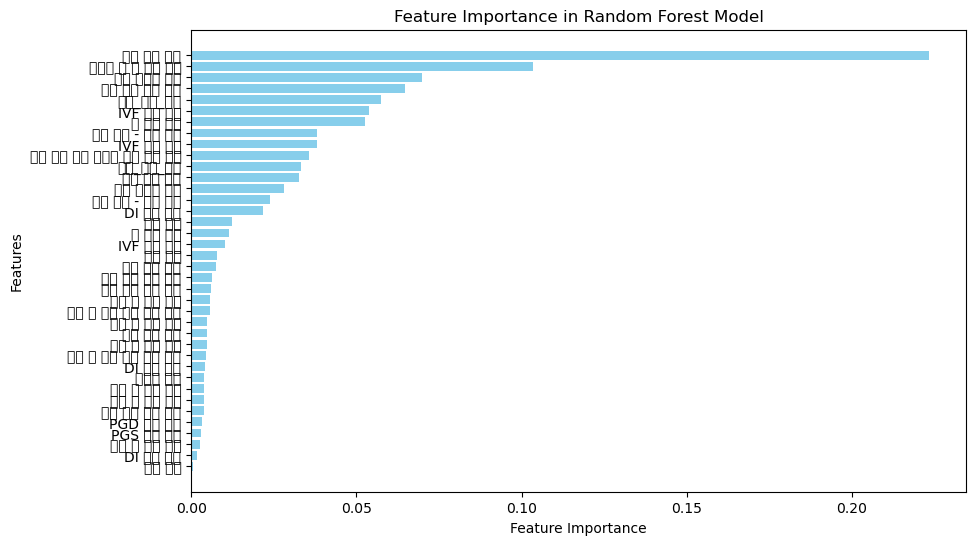

In [23]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, f1_score
import matplotlib.pyplot as plt

# 📌 데이터 로드
train_path = "/Users/yudayeon/Desktop/캡스톤_결과/open/train_cleaned.csv"
train_df = pd.read_csv(train_path, encoding="utf-8")

# 📌 결과 변수 지정 (결과 변수명을 실제 데이터에 맞게 변경)
target_variable = "임신 성공 여부"  # 예: '출산 성공 여부', '임신 여부' 등

# 📌 사용할 변수 리스트 (유의미한 변수만 사용)
significant_features = [
    "단일 배아 이식 여부", "신선 배아 사용 여부", "기증 배아 사용 여부", "시술 유형", "대리모 여부",
    "불임 원인 - 남성 요인", "배란 자극 여부", "착상 전 유전 진단 사용 여부", "불임 원인 - 배란 장애",
    "여성_불임_개수", "정자 출처", "정자 기증자 나이", "IVF 출산 횟수", "총 출산 횟수",
    "시술 시기 코드", "IVF 임신 횟수", "PGD 시술 여부", "DI 출산 횟수",
    "동결 배아 사용 여부", "DI 임신 횟수", "PGS 시술 여부", "남성 주 불임 원인",
    "부부 부 불임 원인", "여성 주 불임 원인", "남성 부 불임 원인", "여성 부 불임 원인",
    "부부 주 불임 원인", "DI 시술 횟수", "임신 시도 또는 마지막 임신 경과 연수",
    "착상 전 유전 검사 사용 여부", "시술_유형_개수", "특정 시술 유형", "난자 기증자 나이",
    "배란 유도 유형", "난자 출처", "클리닉 내 총 시술 횟수", "IVF 시술 횟수", "총 시술 횟수"
]

# 📌 유의미한 변수만 포함한 데이터셋 생성
X = train_df[significant_features]
y = train_df[target_variable]

# 📌 학습 데이터 분할 (Train 80% / Test 20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# 📌 랜덤 포레스트 모델 학습
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# 📌 예측 및 평가
y_pred = rf_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average="weighted")

print(f"✅ 랜덤 포레스트 모델 성능:")
print(f"🎯 정확도(Accuracy): {accuracy:.4f}")
print(f"🎯 F1-score: {f1:.4f}")

# 📌 교차 검증 (5-Fold CV)
cv_scores = cross_val_score(rf_model, X, y, cv=5, scoring='accuracy')
print(f"📌 5-Fold CV 평균 정확도: {np.mean(cv_scores):.4f}")

# 📌 변수 중요도 시각화
feature_importances = pd.DataFrame({'Feature': X_train.columns, 'Importance': rf_model.feature_importances_})
feature_importances = feature_importances.sort_values(by="Importance", ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(feature_importances["Feature"], feature_importances["Importance"], color="skyblue")
plt.xlabel("Feature Importance")
plt.ylabel("Features")
plt.title("Feature Importance in Random Forest Model")
plt.gca().invert_yaxis()
plt.show()

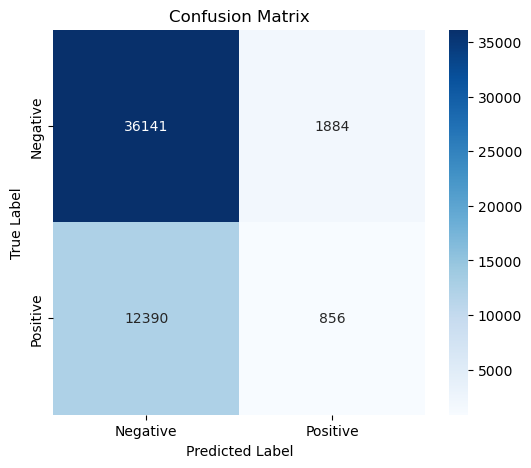

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# 📌 예측값 생성 (이전 모델 학습 후 y_pred 사용)
y_pred = rf_model.predict(X_test)

# 📌 Confusion Matrix 계산
conf_matrix = confusion_matrix(y_test, y_pred)

# 📌 Confusion Matrix 시각화
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Negative", "Positive"], yticklabels=["Negative", "Positive"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()